In [1]:
write = False # log this version as new
MODEL_DESCRIPTION = "Increase KL weight"

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

In [3]:
from tensorflow.keras.models import Model
from keras import backend as K
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [4]:
LATENT_DIM = 256
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
EPOCHS = 200
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 0
# Good value: 1e-6

In [5]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
now = datetime.now()

DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [7]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_training_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation_small.hdf5', 'r')
x_train = np.asarray(hf_train['image'][0:])
x_test = np.asarray(hf_test['image'][0:])
x_validation = np.asarray(hf_validation['image'][0:])
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])
y_test = np.asarray(hf_test['specz_redshift'][0:])
y_validation = np.asarray(hf_validation['specz_redshift'][0:])
# object_id_train = np.asarray(hf_train['object_id'][0:])
# object_id = np.asarray(hf_test['object_id'][0:])
# object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_test.close()
hf_validation.close()

In [8]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)

images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = 1,)
conv1 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(conv1)
flatten = Flatten()(conv2)
dense1 = Dense(1024, activation = None)(flatten)
dense2 = tf.keras.layers.Dense(32, activation = "relu")(redshifts)
dense3 = tf.keras.layers.Dense(32, activation = "relu")(dense2)
concat = tf.keras.layers.Concatenate()([dense1, dense3])
dense4 = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(concat)
z = tfpl.MultivariateNormalTriL(LATENT_DIM,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(dense4)
encoder = Model([images, redshifts], z)

zc = tf.keras.layers.Concatenate()([z, redshifts])

In [9]:
dense5 = Dense(8 * LATENT_DIM * 32 * 32, activation = None)
reshape = Reshape((8 * LATENT_DIM, 32, 32))
conv3 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')
conv4 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')
conv5 = Conv2DTranspose(BASE_DEPTH, 3, strides = 1, activation = leaky_relu, 
                    padding = 'same', data_format = 'channels_first')
conv6 = Conv2D(IMAGE_SHAPE[0], 3, strides = 1, activation = None, 
           padding = 'same', data_format = 'channels_first')
cropping = Cropping2D(cropping=((0, 1), (0, 1)), data_format = 'channels_first')
outputs = Reshape(IMAGE_SHAPE)

In [10]:
dense5_model = dense5(zc)
reshape_model = reshape(dense5_model)
conv3_model = conv3(reshape_model)
conv4_model = conv4(conv3_model)
conv5_model = conv5(conv4_model)
conv6_model = conv6(conv5_model)
cropping_model = cropping(conv6_model)
outputs_model = outputs(cropping_model)

In [11]:
model = Model(inputs = [images, redshifts], outputs = [outputs_model])

In [12]:
latents = Input(shape = (LATENT_DIM + 1, ))
dense5_decoder = dense5(latents)
reshape_decoder = reshape(dense5_decoder)
conv3_decoder = conv3(reshape_decoder)
conv4_decoder = conv4(conv3_decoder)
conv5_decoder = conv5(conv4_decoder)
conv6_decoder = conv6(conv5_decoder)
cropping_decoder = cropping(conv6_decoder)
outputs_decoder = outputs(cropping_decoder)

In [13]:
decoder = Model(latents, outputs_decoder)

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 127, 127) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 64, 64)    368         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 32, 32)    584         conv2d[0][0]                     
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [15]:
model.compile(optimizer = 'adam', loss = 'mse')

In [16]:
run = neptune.init(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

# logs_callback = TensorBoard(log_dir = logs_path)

weights_callback = ModelCheckpoint(filepath = os.path.join(checkpoints_path, 'weights_epoch{epoch}.hdf5'), save_freq = int(EPOCHS/CHECKPOINTS_TO_SAVE), save_weights_only = True)

LR_callback = ReduceLROnPlateau()

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

neptune_callback = NeptuneCallback(run = run)

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-82
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [34]:
history = model.fit(x = [x_train, y_train], y = x_train, epochs = EPOCHS, callbacks = [weights_callback, LR_callback, neptune_callback], validation_data = ([x_validation, y_validation], x_validation), verbose = 1)

Epoch 1/200
313/313 [==============================] - 140s 450ms/step - loss: 0.1027 - val_loss: 0.1211
Epoch 2/200
313/313 [==============================] - 114s 365ms/step - loss: 0.1049 - val_loss: 0.1188
Epoch 3/200
313/313 [==============================] - 118s 378ms/step - loss: 0.1012 - val_loss: 0.1153
Epoch 4/200
313/313 [==============================] - 106s 339ms/step - loss: 0.0985 - val_loss: 0.1199
Epoch 5/200
313/313 [==============================] - 117s 376ms/step - loss: 0.1033 - val_loss: 0.1783
Epoch 6/200
313/313 [==============================] - 105s 338ms/step - loss: 0.1049 - val_loss: 0.1192
Epoch 7/200
313/313 [==============================] - 120s 384ms/step - loss: 0.0935 - val_loss: 0.1253
Epoch 8/200
313/313 [==============================] - 107s 343ms/step - loss: 0.0954 - val_loss: 0.1184
Epoch 9/200
313/313 [==============================] - 121s 387ms/step - loss: 0.1095 - val_loss: 0.1205
Epoch 10/200
313/313 [==============================] -

KeyboardInterrupt: 

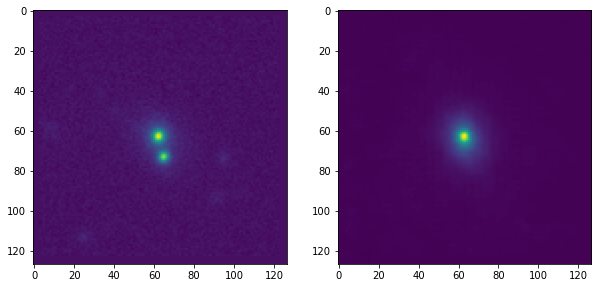

In [45]:
# str = np.zeros((1, LATENT_DIM + 1))
# str[:, LATENT_DIM] = y_train[0]
index = 4
z = 0.01 # y_train[index]
str = np.asarray(encoder([np.array([x_train[index]]), np.array([y_train[index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(x_train[index][4])
axes[1].imshow(decoder.predict([str])[0][4])

In [ ]:
# END